In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-


# Deep Neural Networks

## Session 09b
### Neural Network with :
- pytorch implementation Custom Dataset Class with loader
- One hidden layer 
- ${Tanh}$ activation function
- multi-class - Fashion MNIST dataset (all 60000 images)
- using FashionDS Class implimentation


<img src='../../prasami_images/prasami_color_tutorials_small.png' width='400' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

In [2]:
###-----------------
### Import Libraries
###-----------------

import os
#import numpy as np
import pandas as pd
import sys
sys.path.insert(0, r'G:\My Drive\DNN')
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

from utils.helper import fn_plot_torch_hist, fn_plot_confusion_matrix

In [3]:
###----------------------
### Some basic parameters
###----------------------

inpDir = '../../input'
outDir = '../output'
modelDir = '../models'
subDir = 'pytorch_fashion'

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
torch.manual_seed(RANDOM_STATE) # Set Random Seed for reproducible  results

EPOCHS = 30 # number of epochs
BATCH_SIZE = 32
ALPHA = 0.001 # learning rate
TEST_SIZE = 0.2

# parameters for Matplotlib
params = {'legend.fontsize': 'large',
          'figure.figsize': (15, 10),
          'axes.labelsize': 'large',
          'axes.titlesize':'large',
          'xtick.labelsize':'medium',
          'ytick.labelsize':'medium'
         }

CMAP = plt.cm.coolwarm

plt.rcParams.update(params)

## All about CUDA

In [4]:
print ('Is CUDA available: ', torch.cuda.is_available())

print ('CUDA version: ', torch.version.cuda )

print ('Current Device ID: ', torch.cuda.current_device())

print ('Name of the CUDA device: ', torch.cuda.get_device_name(torch.cuda.current_device()))

Is CUDA available:  True
CUDA version:  12.1
Current Device ID:  0
Name of the CUDA device:  NVIDIA GeForce RTX 3060 Laptop GPU


In [5]:
# Get cpu or gpu device for training.

device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using {device} device")

Using cuda device


## Load Data Set

Loading Fashion MNIST Dataset

<img src = '../../images/pytorch_fashion_mnist.png' alt = 'pytorch_fashion_mnist'>

In [6]:
train_filename = os.path.join(inpDir, 'fashion_mnist', 'fashion-mnist_train.csv')
test_filename = os.path.join(inpDir, 'fashion_mnist', 'fashion-mnist_test.csv')

train_df = pd.read_csv(train_filename, header = 0)
test_df = pd.read_csv(test_filename, header = 0)

In [7]:
labels= {0 : 'T-shirt/top',
         1  : 'Trouser',
         2  : 'Pullover',
         3 : 'Dress',
         4 : 'Coat',
         5 : 'Sandal',
         6 : 'Shirt',
         7 : 'Sneaker',
         8 : 'Bag',
         9 : 'Ankle boot'}

## Dataset Class

In [8]:
'''
In this code, we define a custom dataset called FashionDS 
that takes a DataFrame as input. 

'''

class FashionDS(Dataset):
    
    def __init__(self, dataframe, device = device):

        super(FashionDS, self).__init__

        self.df = dataframe
        
        self.device = device
        
        feat = self.df.drop('label', axis = 1).to_numpy()
        
        self.features = feat / 255.0

        self.labels = self.df.label.to_numpy()

    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):

        # Extract features and label from the dataframe row
        
        features = self.features[index]
        
        labels = self.labels[index]
        
        # Convert to PyTorch tensors
        features = torch.tensor(features, dtype=torch.float32, device=self.device)
        
        labels = torch.tensor(labels, dtype=torch.int64, device=self.device)
        
        return features, labels

In [9]:
# convert to datasets
train_ds = FashionDS(train_df)
test_ds = FashionDS(test_df)

In [10]:
# Define data loaders for the training and testing datasets
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

## Verify Data
Lets check if we are getting proper data

In [11]:
# get one batch
images, targets = next(iter(train_loader))

# move them to CPU and convert to numpy
images = images.cpu().numpy()
targets = targets.cpu().numpy()

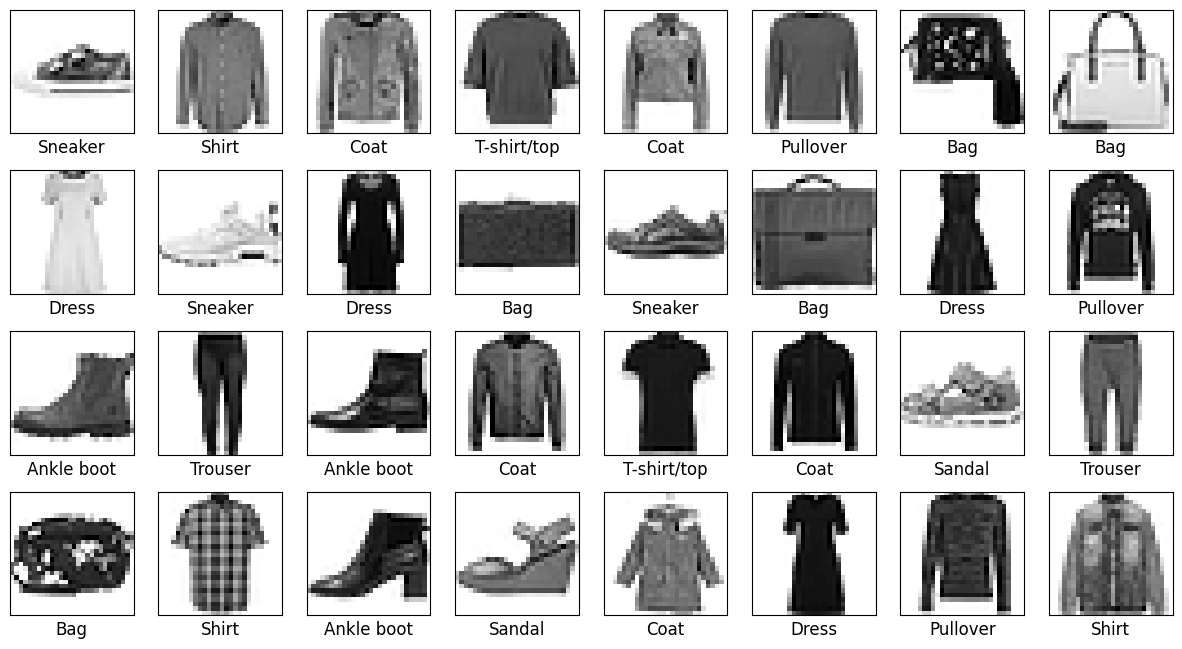

In [12]:
plt.figure(figsize=(15,8))

for i in range(BATCH_SIZE):
    
    plt.subplot(4,8,i+1)
    
    plt.xticks([])
    
    plt.yticks([])
    
    plt.grid(False)
    
    plt.imshow(images[i].reshape(28,28,1), cmap=plt.cm.binary)
    
    plt.xlabel(labels[targets[i]])

plt.show()

## NN Model

In [13]:
class Model(nn.Module):
    
    def __init__(self, input_dim):

        super(Model, self).__init__()
        
        self.layer1 = nn.Linear(input_dim,392)
        
        self.activation1 = nn.Tanh()
        
        self.layer2 = nn.Linear(392, 10)
        
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x):
        
        x = torch.tanh(self.layer1(x))
        
        x = self.activation1(x)
        
        x = self.layer2(x)

        return self.softmax (x)

net = Model(input_dim=train_df.shape[1]-1).to(device) # Create model on GPU

print (net)

Model(
  (layer1): Linear(in_features=784, out_features=392, bias=True)
  (activation1): Tanh()
  (layer2): Linear(in_features=392, out_features=10, bias=True)
  (softmax): LogSoftmax(dim=1)
)


In [14]:
# Define the loss function and optimizer
loss_fn = nn.CrossEntropyLoss() # cross entropy loss

loss, tloss = [],[]
acc, tacc = [],[]
n_epoch = []

optimizer = torch.optim.Adam(net.parameters(), lr=ALPHA)

# Train the model for multiple epochs

for epoch in range(EPOCHS):
    
    # Training loop
    train_loss = 0.0
    train_acc = 0.0
    
    for i, data in enumerate(train_loader):
        
        inputs, targets = data
        
        optimizer.zero_grad()
        
        outputs = net(inputs)
        
        preds = torch.argmax(outputs, dim = 1)
        
        batch_loss = loss_fn(outputs, targets)
        batch_acc = accuracy_score(targets.cpu().numpy(), preds.cpu().numpy())
        
        batch_loss.backward()
        
        optimizer.step()
        
        train_loss += batch_loss.item() * inputs.size(0)
        train_acc += batch_acc * inputs.size(0)
    
    train_loss /= len(train_ds)
    train_acc /= len(train_ds)
    
    loss.append(train_loss)
    acc.append(train_acc)
    
    # Testing loop
    test_loss = 0.0
    test_acc = 0.0
    
    with torch.no_grad():
        
        for data in test_loader:
            
            inputs, targets = data
            
            outputs = net(inputs)
            
            preds = torch.argmax(outputs, dim = 1)
            
            batch_loss = loss_fn(outputs, targets)

            batch_acc = accuracy_score(targets.cpu().numpy(), preds.cpu().numpy())
            
            test_loss += batch_loss.item() * inputs.size(0)
            test_acc += batch_acc* inputs.size(0)
        
        test_loss /= len(test_ds)
        test_acc /= len(test_ds)
    
        tloss.append(test_loss)
        tacc.append(test_acc)
    n_epoch.append(epoch)
    
    print(f'At epoch{epoch:2d} | Loss: {train_loss:.4f}/{test_loss:.4f} | Acc: {train_acc:.4f}/{test_acc:.4f}')

At epoch 0 | Loss: 0.4786/0.3788 | Acc: 0.8248/0.8659
At epoch 1 | Loss: 0.3773/0.3855 | Acc: 0.8619/0.8597
At epoch 2 | Loss: 0.3429/0.3947 | Acc: 0.8738/0.8523
At epoch 3 | Loss: 0.3215/0.3274 | Acc: 0.8807/0.8853
At epoch 4 | Loss: 0.3061/0.3370 | Acc: 0.8862/0.8762
At epoch 5 | Loss: 0.2938/0.3220 | Acc: 0.8906/0.8835
At epoch 6 | Loss: 0.2827/0.3083 | Acc: 0.8946/0.8864
At epoch 7 | Loss: 0.2733/0.3168 | Acc: 0.8975/0.8856
At epoch 8 | Loss: 0.2671/0.3381 | Acc: 0.9008/0.8782
At epoch 9 | Loss: 0.2585/0.3200 | Acc: 0.9026/0.8851
At epoch10 | Loss: 0.2550/0.3143 | Acc: 0.9051/0.8848
At epoch11 | Loss: 0.2476/0.3165 | Acc: 0.9066/0.8865
At epoch12 | Loss: 0.2397/0.3217 | Acc: 0.9120/0.8824
At epoch13 | Loss: 0.2363/0.3193 | Acc: 0.9107/0.8842
At epoch14 | Loss: 0.2311/0.3127 | Acc: 0.9133/0.8904
At epoch15 | Loss: 0.2268/0.3306 | Acc: 0.9152/0.8821
At epoch16 | Loss: 0.2214/0.3062 | Acc: 0.9164/0.8924
At epoch17 | Loss: 0.2184/0.3228 | Acc: 0.9190/0.8882
At epoch18 | Loss: 0.2134/0.

In [15]:
loss_df = pd.DataFrame({'epoch' : n_epoch, 'loss' : loss, 'test_loss': tloss, 'acc' : acc, 'test_acc': tacc})
loss_df.head()

,epoch,loss,test_loss,acc,test_acc
0,0,0.478553,0.378832,0.824767,0.8659
1,1,0.377329,0.385451,0.861850,0.8597
2,2,0.342884,0.394670,0.873833,0.8523
3,3,0.321519,0.327356,0.880733,0.8853
4,4,0.306062,0.337010,0.886167,0.8762


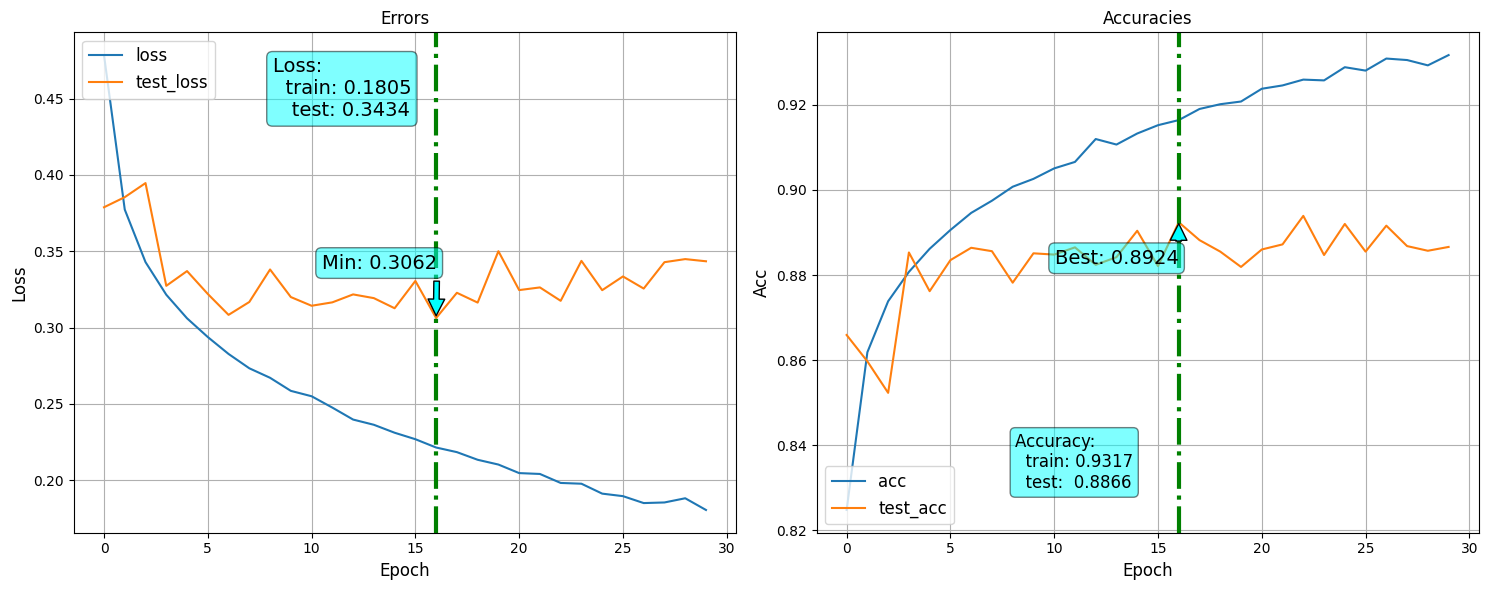

In [16]:
fn_plot_torch_hist(loss_df)

In [17]:
# we transform all our features with the scaler
X_scaled_all = train_df.drop('label', axis = 1).to_numpy() / 255.

# transform in tensors
X_scaled_all_tensors = torch.tensor(X_scaled_all, dtype=torch.float32).to(device)

# we set the model in inference mode and create the predictions
with torch.inference_mode():
    logits = net(X_scaled_all_tensors)
    predictions = logits.argmax(dim = 1)
    
train_df['pred'] = predictions.cpu().numpy()

In [18]:
y_pred = train_df['pred'].to_numpy()
y_train = train_df['label']
print('Accuracy score on Train Data :', accuracy_score(y_train, y_pred))

Accuracy score on Train Data : 0.9335666666666667


In [19]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.93      0.91      6000
           1       1.00      0.99      0.99      6000
           2       0.95      0.74      0.84      6000
           3       0.94      0.96      0.95      6000
           4       0.84      0.89      0.87      6000
           5       1.00      1.00      1.00      6000
           6       0.77      0.87      0.82      6000
           7       0.99      0.99      0.99      6000
           8       1.00      0.99      0.99      6000
           9       0.99      0.99      0.99      6000

    accuracy                           0.93     60000
   macro avg       0.94      0.93      0.93     60000
weighted avg       0.94      0.93      0.93     60000



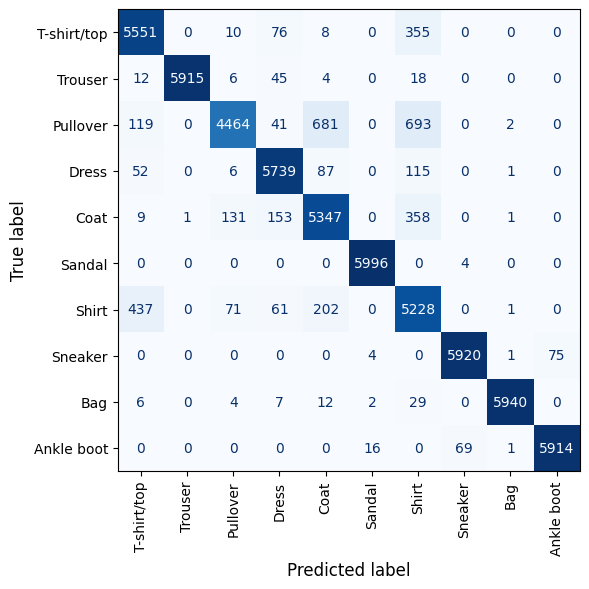

In [20]:
fn_plot_confusion_matrix(y_train, y_pred, labels=labels)

In [21]:
# we transform all our features with the scaler
X_scaled_all = test_df.drop('label', axis = 1).to_numpy() / 255.

# transform in tensors
X_scaled_all_tensors = torch.tensor(X_scaled_all, dtype=torch.float32).to(device)

# we set the model in inference mode and create the predictions
with torch.inference_mode():
    logits = net(X_scaled_all_tensors)
    predictions = logits.argmax(dim = 1)
    
test_df['pred'] = predictions.cpu().numpy().flatten()

In [22]:
y_pred = test_df['pred'].to_numpy()
y_test = test_df['label']
print('Accuracy score on Train Data :', accuracy_score(y_test, y_pred))

Accuracy score on Train Data : 0.8866


In [23]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.85      0.83      1000
           1       0.99      0.98      0.98      1000
           2       0.91      0.68      0.78      1000
           3       0.90      0.92      0.91      1000
           4       0.81      0.86      0.83      1000
           5       0.97      0.95      0.96      1000
           6       0.66      0.76      0.70      1000
           7       0.93      0.95      0.94      1000
           8       0.98      0.97      0.97      1000
           9       0.95      0.96      0.95      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



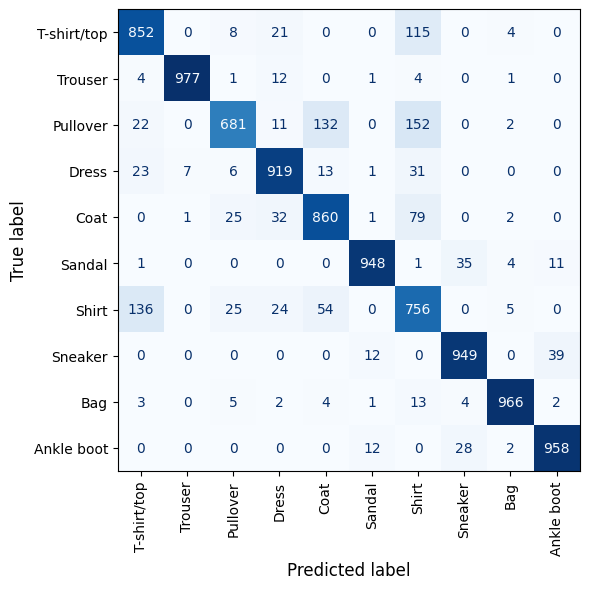

In [24]:
fn_plot_confusion_matrix(y_test, y_pred, labels=labels)

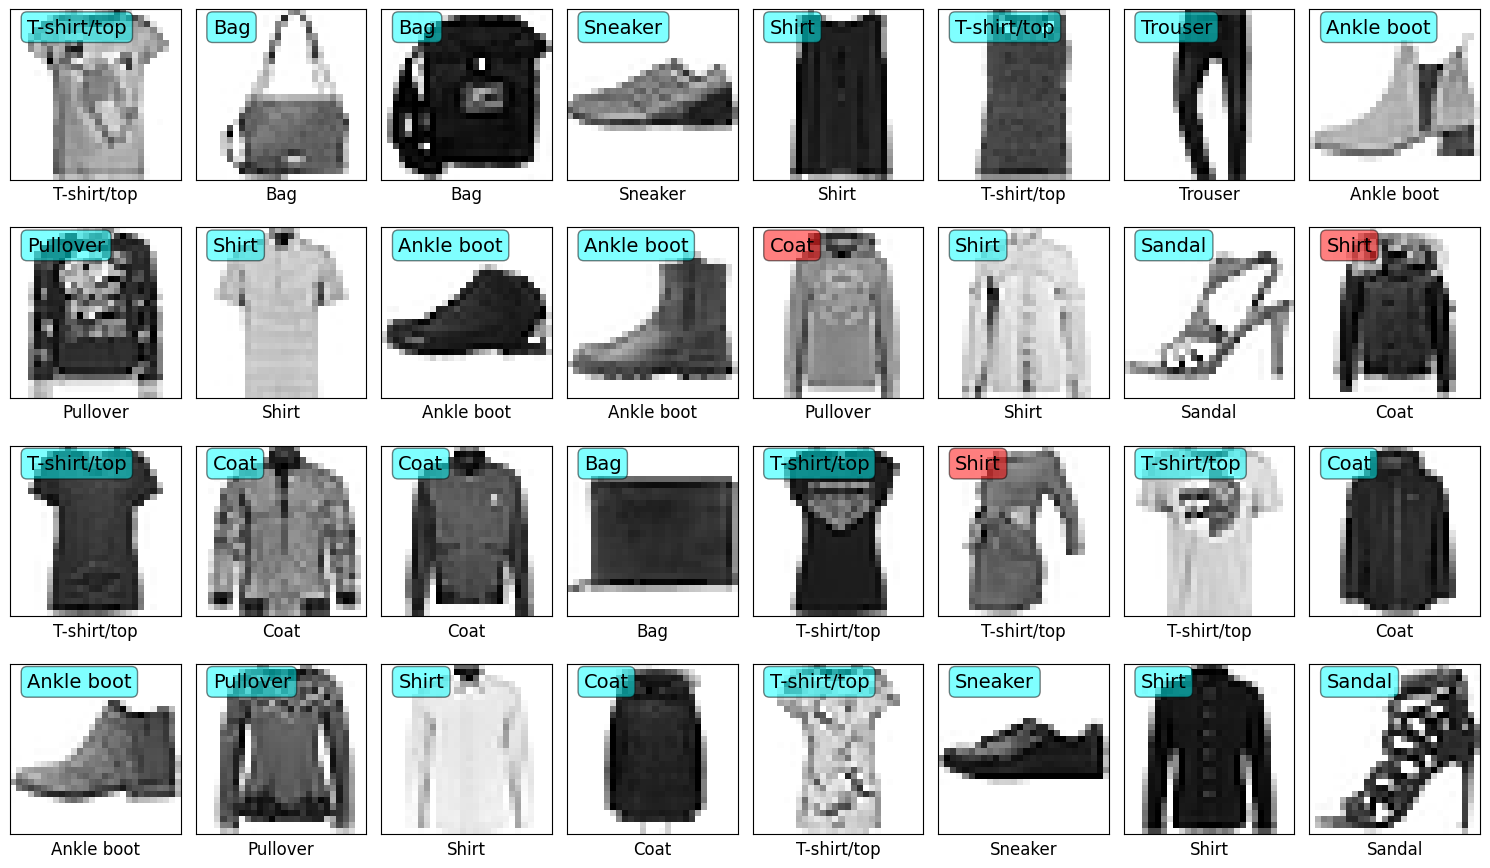

In [25]:
plot_df = test_df.sample(n=32)

y_test_plot = plot_df.label.to_numpy()
y_pred_plot = plot_df.pred.to_numpy()

X_plot = plot_df.drop(['label', 'pred'], axis = 1).to_numpy() / 255.


plt.figure(figsize=(15,9))


for i in range(32):
    ax = plt.subplot(4,8,i+1)
    # properties  matplotlib.patch.Patch 
    if y_test_plot[i]!= y_pred_plot[i]:
        color = 'red'
    else:
        color = 'cyan'
        
    props = dict(boxstyle='round', facecolor=color, alpha=0.5)
    
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_plot[i].reshape(28,28,1), cmap=plt.cm.binary)
    plt.xlabel(labels[y_test_plot[i]])
    # place a text box in upper middle in axes coords
    ax.text(0.1, 0.95, labels[y_pred_plot[i]], transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)
    plt.tight_layout()
plt.show()